In [100]:
import pandas as pd
import numpy as np
from typing import Dict, Optional
import nannyml as nml

In [101]:
%load_ext kedro.ipython

The kedro.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.ipython


In [102]:
wine_raw = catalog.load('wine_raw_data')

[06/28/25 15:26:50] INFO     Loading data from wine_raw_data (CSVDataset)...                    ]8;id=504673;file:///Users/svengoerdes/Projects/Master/MLOps_Project/project/.venv/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=856670;file:///Users/svengoerdes/Projects/Master/MLOps_Project/project/.venv/lib/python3.9/site-packages/kedro/io/data_catalog.py#403\403]8;;\

<Axes: xlabel='points'>

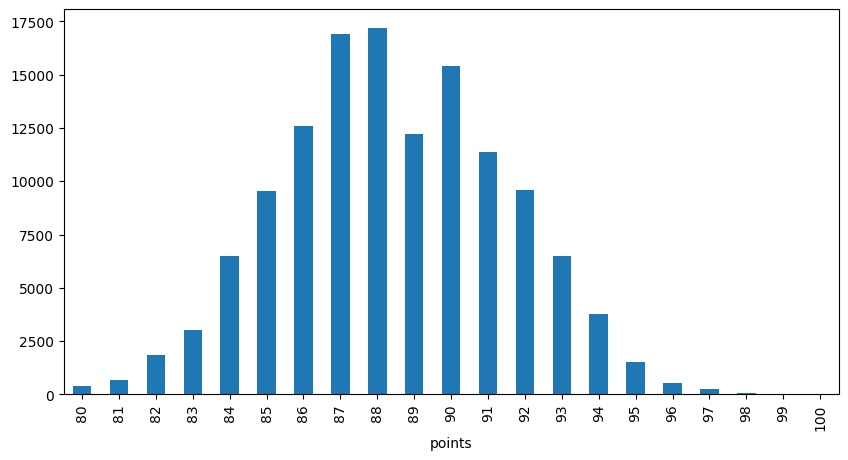

In [103]:
# lets look at the current distribution ofthe points
wine_raw['points'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))

In [104]:
wine_raw['points'].describe()


count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [105]:
# lets take a sample of the original data and shift the data ponts by - 20 
wine_sample = wine_raw.sample(30000, random_state=42)
# lets use a normal distrubtion to generate a new set of points
np.random.normal(loc = -5 ,scale = 3)

-5.80477299947163

In [106]:
data_shift = np.random.normal(loc = -10 ,scale = 3, size = 30000)
wine_sample['points'] = wine_sample['points'] + data_shift

In [107]:
# make sure that every value is between [0, 100] -> if not this should get caught by great_expectations.
wine_sample.describe()


,points,price
count,30000.000000,27894.000000
mean,78.448975,35.394744
std,4.288730,41.523193
min,61.306618,4.000000
25%,75.537713,17.000000
50%,78.425306,25.000000
75%,81.355435,42.000000
max,95.083682,2013.000000


In [108]:
wine_sample.reset_index(inplace= True, drop=True)

# wine_sample.drop(columns=['index'], inplace=True)

In [109]:
wine_sample.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Australia,"Possibly a little sweet, this is a soft, easyg...",NaN,67.935755,5.0,Australia Other,South Eastern Australia,NaN,Joe Czerwinski,@JoeCz,Banrock Station 2006 Chardonnay (South Eastern...,Chardonnay,Banrock Station
1,France,"A soft, almost off dry wine that is full in th...",Réserve,68.970164,12.0,Rhône Valley,Côtes du Rhône,NaN,Roger Voss,@vossroger,Cellier des Dauphins 2015 Réserve Rosé (Côtes ...,Rosé,Cellier des Dauphins
2,Spain,Generic white-fruit aromas of peach and apple ...,Estate Grown & Bottled,77.238402,9.0,Northern Spain,Rueda,NaN,Michael Schachner,@wineschach,Esperanza 2013 Estate Grown & Bottled Verdejo-...,Verdejo-Viura,Esperanza
3,US,This is the winery's best Nebula in years. Whi...,Nebula,76.716487,29.0,California,Paso Robles,Central Coast,NaN,NaN,Midnight 2010 Nebula Cabernet Sauvignon (Paso ...,Cabernet Sauvignon,Midnight
4,US,This is a very rich Pinot whose primary virtue...,Wiley Vineyard,76.235308,40.0,California,Anderson Valley,NaN,NaN,NaN,Harrington 2006 Wiley Vineyard Pinot Noir (And...,Pinot Noir,Harrington


In [110]:
# save this new data_sample with new distribution to winemag-data-datadrift
wine_sample.to_csv('../data/01_raw/winemag_data_drift.csv')

In [111]:
# --- Helper Function ---
def _add_timestamp_from_index(df: pd.DataFrame, ts_col_name: str) -> pd.DataFrame:
    """
    Takes a DataFrame, creates a copy, and adds a new column 
    named `ts_col_name` from the DataFrame's index.
    """
    df_copy = df.copy()
    # reset_index() converts the index into a column named 'index'
    df_copy = df_copy.reset_index()
    # Rename it to the name specified in our parameters
    df_copy = df_copy.rename(columns={'index': ts_col_name})
    return df_copy

# --- Main Nodes (Updated) ---

# The data splitting and drift introduction nodes remain the same.

def detect_univariate_drift(
    reference_df: pd.DataFrame, 
    analysis_df: pd.DataFrame, 
    params: Dict
) -> pd.DataFrame:
    """Calculates univariate drift using the DataFrame's index as the timestamp."""
    
    ts_col = params['timestamp_column']
    
    # Use the helper to prepare data for NannyML
    reference_df_nml = _add_timestamp_from_index(reference_df, ts_col)
    analysis_df_nml = _add_timestamp_from_index(analysis_df, ts_col)

    print("Detecting univariate drift...")
    calc = nml.UnivariateDriftCalculator(
        column_names=params['features_to_monitor'],
        timestamp_column_name=ts_col,
        chunk_size=params['chunk_size']
    ).fit(reference_data=reference_df_nml)
    
    results = calc.calculate(data=analysis_df_nml)
    return results.to_df()

In [112]:
wine_sample_drift = _add_timestamp_from_index(wine_sample, 'record_id')

In [113]:
# load the params from parameters_data_drift.yml
params = catalog.load('params:data_drift')

[06/28/25 15:26:51] INFO     Loading data from params:data_drift (MemoryDataset)...             ]8;id=652667;file:///Users/svengoerdes/Projects/Master/MLOps_Project/project/.venv/lib/python3.9/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=15656;file:///Users/svengoerdes/Projects/Master/MLOps_Project/project/.venv/lib/python3.9/site-packages/kedro/io/data_catalog.py#403\403]8;;\

In [114]:
params


{
    'features_to_monitor': ['points'],
    'timestamp_column': 'record_id',
    'target_column': 'price',
    'prediction_column': 'y_pred',
    'chunk_size': 100
}

In [115]:
wine_raw.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [116]:
print(wine_raw.columns)

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')


In [117]:
duplicated_columns = wine_raw.columns[wine_raw.columns.duplicated()]
duplicated_columns

Index([], dtype='object')

In [118]:
duplicated_columns = wine_sample_drift.columns[wine_sample_drift.columns.duplicated()]
duplicated_columns

Index([], dtype='object')

In [119]:
wine_sample_drift.head()

,record_id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Australia,"Possibly a little sweet, this is a soft, easyg...",NaN,67.935755,5.0,Australia Other,South Eastern Australia,NaN,Joe Czerwinski,@JoeCz,Banrock Station 2006 Chardonnay (South Eastern...,Chardonnay,Banrock Station
1,1,France,"A soft, almost off dry wine that is full in th...",Réserve,68.970164,12.0,Rhône Valley,Côtes du Rhône,NaN,Roger Voss,@vossroger,Cellier des Dauphins 2015 Réserve Rosé (Côtes ...,Rosé,Cellier des Dauphins
2,2,Spain,Generic white-fruit aromas of peach and apple ...,Estate Grown & Bottled,77.238402,9.0,Northern Spain,Rueda,NaN,Michael Schachner,@wineschach,Esperanza 2013 Estate Grown & Bottled Verdejo-...,Verdejo-Viura,Esperanza
3,3,US,This is the winery's best Nebula in years. Whi...,Nebula,76.716487,29.0,California,Paso Robles,Central Coast,NaN,NaN,Midnight 2010 Nebula Cabernet Sauvignon (Paso ...,Cabernet Sauvignon,Midnight
4,4,US,This is a very rich Pinot whose primary virtue...,Wiley Vineyard,76.235308,40.0,California,Anderson Valley,NaN,NaN,NaN,Harrington 2006 Wiley Vineyard Pinot Noir (And...,Pinot Noir,Harrington


In [120]:
detect_univariate_drift(wine_raw, wine_sample_drift, params)

Detecting univariate drift...


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/svengoerdes/Projects/Master/MLOps_Project/project/.venv/lib/python3.9/site-packages/nanny │
│ ml/base.py:370 in calculate                                                                      │
│                                                                                                  │
│   367 │   │   """Performs a calculation on the provided data."""                                 │
│   368 │   │   try:                                                                               │
│   369 │   │   │   self._logger.debug(f"calculating {str(self)}")                                 │
│ ❱ 370 │   │   │   return self._calculate(data, *args, **kwargs)                                  │
│   371 │   │   except NannyMLException:                                                           │
│   372 │   │   │   raise                                                                          │
│   373 │   │   except Exception as exc:                                                           │
│                                                                                                  │
│ /Users/svengoerdes/Projects/Master/MLOps_Project/project/.venv/lib/python3.9/site-packages/nanny │
│ ml/usage_logging.py:242 in logging_wrapper                                                       │
│                                                                                                  │
│   239 │   │   │   │   logger.log(usage_event, md)                                                │
│   240 │   │   │   finally:                                                                       │
│   241 │   │   │   │   if runtime_exception is not None:                                          │
│ ❱ 242 │   │   │   │   │   raise runtime_exception                                                │
│   243 │   │   │   │   else:                                                                      │
│   244 │   │   │   │   │   return res                                                             │
│   245                                                                                            │
│                                                                                                  │
│ /Users/svengoerdes/Projects/Master/MLOps_Project/project/.venv/lib/python3.9/site-packages/nanny │
│ ml/usage_logging.py:191 in logging_wrapper                                                       │
│                                                                                                  │
│   188 │   │   │   runtime_exception = None                                                       │
│   189 │   │   │   try:                                                                           │
│   190 │   │   │   │   # run original function                                                    │
│ ❱ 191 │   │   │   │   res = func(*args, **kwargs)                                                │
│   192 │   │   │   except BaseException as exc:                                                   │
│   193 │   │   │   │   runtime_exception = exc                                                    │
│   194                                                                                            │
│                                                                                                  │
│ /Users/svengoerdes/Projects/Master/MLOps_Project/project/.venv/lib/python3.9/site-packages/nanny │
│ ml/drift/univariate/calculator.py:327 in _calculate                                              │
│                                                                                                  │
│   324 │   │                                                                                      │
│   325 │   │   _list_missing(self.column_names, data)                                             │
│   326 │   │                                                